# Price Prediction by Nueral Network

## Dataset

Four years, 3/1/2015 to 3/1/2019, dairy based price data of EUR/USD

## Topics

- Create a model of 1 dimensional CNN and make it predict the future prices
- Execute a trading simulation by following model prediction

In [1]:
import keras
from keras.models import Sequential
from keras.layers import (
    Dense, Conv1D, MaxPooling1D, CuDNNLSTM, Dropout, Activation
)
from keras.optimizers import Adam
from keras.layers.core import Flatten

import numpy as np
import pandas as pd

from oandaapi import get_exrate_as_df

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
df = get_exrate_as_df(instrument='EUR_USD', from_='2015-03-01', to='2019-03-01')

In [3]:
print(len(df))
df.tail()

1040


,open,high,low,close,volume
time,,,,,
2019-02-24 22:00:00,1.13359,1.13675,1.13286,1.13574,13830.0
2019-02-25 22:00:00,1.13616,1.14028,1.13453,1.13892,17286.0
2019-02-26 22:00:00,1.13894,1.14036,1.13624,1.13695,16900.0
2019-02-27 22:00:00,1.13673,1.14197,1.13596,1.13706,20344.0
2019-02-28 22:00:00,1.13706,1.14086,1.13532,1.13648,17278.0


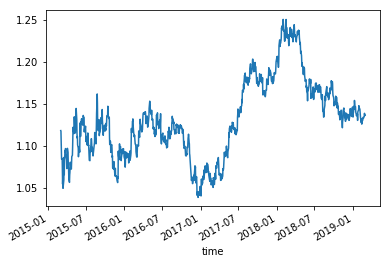

In [4]:
df['close'].plot()
plt.show()

In [5]:
mean = df['close'].mean()
std = df['close'].std()

In [6]:
normed_data = np.array((df['close'] - mean) / std)
normed_data

array([-0.28581342, -0.30120335, -0.50918126, ...,  0.11154622,
        0.11389746,  0.10150001])

In [7]:
def create_train_test_data(data, span, slide, train_rate):
    train_size = int(train_rate*len(data))
    
    X, y = [], []
    for i in range(span, len(data)-1, slide):
        X.append(data[i-span:i])
        y.append(data[i+1])
    X = np.array(X).reshape((-1, span, 1))
    y = np.array(y).reshape((-1, 1))
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    return X_train, y_train, X_test, y_test

Separate the dataset and make train data and test data.
The ratio of train and test is 6:4.

In [8]:
X_train, y_train, X_test, y_test =    \
    create_train_test_data(normed_data, span=20, slide=1, train_rate=0.6)

## CNN Model Construction

In [10]:
input_shape = (20, 1)

model = Sequential()
model.add(Conv1D(
    32, 3, activation='relu', padding='valid',
    input_shape=input_shape
))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,
                 3,
                 activation='relu',
                 padding='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Learning

The batch and epoch size are determined as 200 and 50 respectively.

In [11]:
epoch = 50
batch_size = 200
history = model.fit(X_train, y_train, epochs=epoch,
                      batch_size=batch_size,
                      validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 624 samples, validate on 395 samples
Epoch 1/50
624/624 [==============================] - 1s 978us/step - loss: 0.3497 - acc: 0.0000e+00 - val_loss: 1.3324 - val_acc: 0.0000e+00
Epoch 2/50
624/624 [==============================] - 0s 99us/step - loss: 0.2611 - acc: 0.0000e+00 - val_loss: 0.6464 - val_acc: 0.0000e+00
Epoch 3/50
624/624 [==============================] - 0s 129us/step - loss: 0.1866 - acc: 0.0000e+00 - val_loss: 0.2310 - val_acc: 0.0000e+00
Epoch 4/50
624/624 [==============================] - 0s 92us/step - loss: 0.1675 - acc: 0.0000e+00 - val_loss: 0.0874 - val_acc: 0.0000e+00
Epoch 5/50
624/624 [==============================] - 0s 91us/step - loss: 0.1473 - acc: 0.0000e+00 - val_loss: 0.1282 - val_acc: 0.0000e+00
Epoch 6/50
624/624 [==============================] - 0s 109us/step - loss: 0.1379 - acc: 0.0000e+00 - val_loss: 0.2317 - val_acc: 0.0000e+00
Epoch 7/50
624/624 [==============================] - 0s 

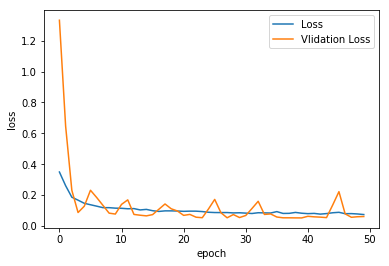

In [12]:
plt.plot(range(epoch), history.history['loss'], label='Loss')
plt.plot(range(epoch), history.history['val_loss'], label='Vlidation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend() 
plt.show()

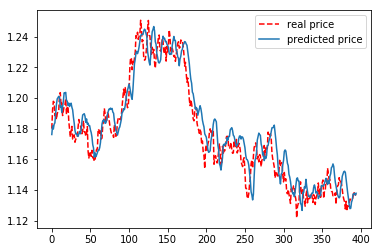

In [13]:
prediction = model.predict(X_test)
plt.plot( y_test * std+mean ,label='real price', color='r', linestyle='--')
plt.plot(prediction * std +mean, label='predicted price' )
plt.legend()
plt.show()

## Trading Simulation

To evaluate the effectiveness of the CNN model, the trading simulation was executed.
In this simulation, a trader will take positions the roles as follows.
1. Must take Long or Short position
2. Know the open price and predicted price
3. Take Long position if the predicted price is greater than the open price
4. Take Short position if the predicted price is smaller than the open price
5. Get profits if the position is right

In [14]:
def take_position_by_prediction(open_price, real_price, predicted_price):
    if predicted_price > open_price:    # Take Long Position
        return real_price - open_price
    else:                                                   # Take Short Position
        return open_price - real_price

def trade_simulation(start_price, model, X_test, y_test, mean, std):
    earnings = np.zeros(len(y_test))
    span = len(X_test[0])
    for i in range(len(y_test)):
        open_price = start_price if i == 0 else y_test[i-1][0]*std + mean
        real_price = y_test[i][0]*std + mean
        y = model.predict(X_test[i].reshape(1, span, -1))[0][0]
        predicted_price = y*std + mean
        one_day_earning = take_position_by_prediction(open_price, real_price, predicted_price)
        earnings[i] = one_day_earning if i == 0 else one_day_earning + earnings[i-1]
    return earnings

In [15]:
start_price = y_train[-1][0]
earnings = trade_simulation(start_price, model, X_test, y_test, mean, std)

Max: 21.33 % Min: 10.92 %


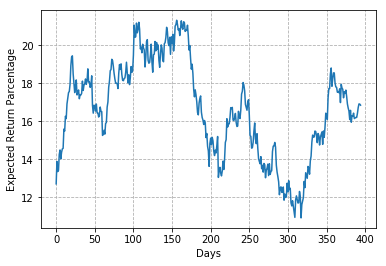

In [16]:
earnings_pct = earnings*100/start_price
print('Max: {0:.2f} %'.format(earnings_pct.max()) , 'Min: {0:.2f} %'.format(earnings_pct.min()))
plt.plot(earnings*100/start_price)
plt.xlabel('Days')
plt.ylabel('Expected Return Parcentage')
plt.grid(linestyle='--')
plt.show()